Minimal-work protocols for inertial particles in non-harmonic traps

###Installation

We need the following imports

In [3]:
import pandas as pd
import numpy as np
import numpy.random as npr
import ot #Python Optimal transport

from scipy.ndimage import median_filter,generic_filter
import scipy.ndimage as sc
import scipy.interpolate as sci
import scipy.constants as constant
import scipy.signal as signal

from sklearn.neighbors import KernelDensity

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib.legend_handler import HandlerBase

#auto downloading
from google.colab import files

In [4]:
#for tex plots
import matplotlib as mpl
mpl.rcParams.update({
    "axes.formatter.limits": [-2, 4],#set limits for display text in plots
    "font.family": "serif",  # use serif/main font for text elements
    "pgf.rcfonts": False,     # don't setup fonts from rc parameters
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,    # use inline math for ticks
    "pgf.preamble": "\n".join([
      r"\usepackage{amsmath}",
      r"\usepackage{amsfonts}"])            # load additional packages
      })

###Boundary Conditions

Set up the time discretisation

In [5]:
#initialise expansion parameters and time discretisation
epsilon = 0.2 #0.2 #0.01
T = 2 #final time for t0
Tf = (epsilon**2)*T  #final time for t2
h_step = 0.0001#FOR T=2 use: 0.0001 #0.000025#for histograms: 0.0001
#decimal places for the time lookup.
dps =  int(np.ceil(-np.log10(h_step))+1)
t_steps = int(Tf/h_step) + 1 #number of timesteps
t2_vec = np.round(np.linspace(0,Tf,t_steps,endpoint = True),dps)


We begin by initialising the boundary conditions.

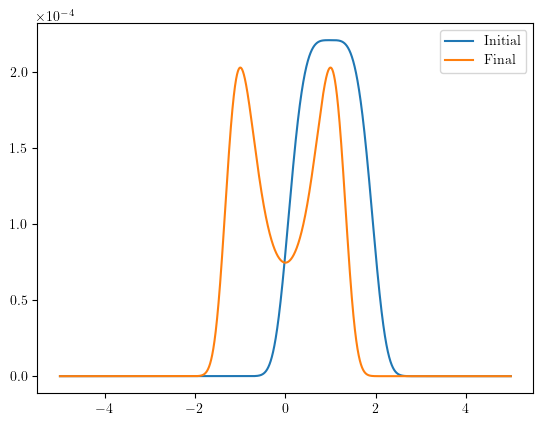

In [6]:
#boundary conditions
n = 25000  # number of samples in the histograms

#set up the boundary conditions
peak_center = 1
denom = 1
xmin = -5
xmax = 5

q = np.linspace(xmin,xmax,n) #fixed axes of points
qnorm = np.linspace(-15,15,500000) #used for computing the normalisation
qchoice = np.linspace(xmin,xmax,n*100) #points to choose from for histograms


#exact boundary conditions
def p_initial_unnormalised(q):
  return np.exp(-(q-peak_center)**4/denom)
def p_final_unnormalised(q):
  return np.exp(-(((q**2 -peak_center**2)**2)/denom))

#compute normalisation constacomputents
p_initialnorm = p_initial_unnormalised(qnorm)
p_finalnorm = p_final_unnormalised(qnorm)
pi_norm = np.abs(np.trapz(p_initialnorm,qnorm))
pf_norm = np.abs(np.trapz(p_finalnorm,qnorm))

#normalised boundary conds
def p_initial(q):
  return p_initial_unnormalised(q)/pi_norm
def p_final(q):
  return p_final_unnormalised(q)/pf_norm


pi = p_initial(q)
pf = p_final(q)
pi /= sum(pi)
pf /= sum(pf)

#visualise the initial conditions
plt.plot(q,pi,label="Initial")
plt.plot(q,pf,label="Final")
plt.legend()
plt.show()

In [7]:
#get weights of samples
pichoice = p_initial(qchoice)
pfchoice = p_final(qchoice)
pichoice /= sum(pichoice)
pfchoice /= sum(pfchoice)

###Optimal Assignment


Now that this is set up, we can solve the Optimal Transport problem, that is, the cell problem at second order, Eqs (5).

In [ ]:
#make histograms of points
xs = npr.choice(qchoice, size = n, p = pichoice)
xt = npr.choice(qchoice, size = n, p = pfchoice)

#solve OT problem using Python OT
G0_data = ot.emd2_1d(xs.reshape((n, 1)), xt.reshape((n, 1)),log=True)

#save the assignment and W2 distance
G0 = G0_data[1]["G"]
w2_dist = G0_data[0]

With the optimal assignment between points computed, we can now compute the trajectories of the point for a time discretisation given by t_range. This is done by a linear interpolation in time from beginning to end state, see eq. (8). This results in point clouds which are then used to estimate the intermediate densities. Additionally, we estimate the corresponding Burgers velocity ($\partial\lambda$) for these points.


The cell problem is at second order in the expansion parameter epsilon, so we must rescale the final time.

Finally the results are saved into a pandas dataframe.

In [ ]:
df_orig = pd.DataFrame()


In [ ]:
#find lagrangian trajectories and burgers velocities
def get_rho_lambda(i,G0,xt):

  '''input:
  - i: index of the initial coordinate
  - t: time of evaluation

  returns:
  - l_map: approximation of the dynamic lagrangian map between the two distributions as a function of time
  - dsigma_x: dsigma (burger's velocity) evaluated at time (index) and x (l_map)
  '''

  idx_j = 0

  #get matching coordinate
  for j in range(0,n):
    if G0[i,j] > 0:
      idx_j = j
      break

  #get initial and final points
  xinit = xs[i]
  xfinal = xt[idx_j]

  #make (discrete) lagrangian maps
  l_map = np.ones(t_steps)
  for t in range(0,t_steps):
    tcurr = t2_vec[t]
    l_map[t] = ((Tf - tcurr)/Tf)*xinit + (tcurr/Tf)*xfinal

  #get burgers velocity (dsigma)
  dsigma_x = np.ones(t_steps)
  for x in enumerate(l_map):
    #evaluate sigma at x
    dsigma_x[x[0]] = (1/Tf)*(xfinal - xinit)

  return t2_vec,l_map,dsigma_x

#ts = []
#x_vals = []
#dsigs = []


for x in enumerate(xs):
  result = get_rho_lambda(x[0],G0,xt)

  #append straight to dataframe

  #make new df with these

  columns=["t","x","dsigma"]

  #append new
  df2append = pd.DataFrame(dict(zip(columns, result)))
  df_orig = pd.concat([df_orig,df2append])
  #ts.append(result[0])
  #x_vals.append(result[1])
  #dsigs.append(result[2])

#get results to put into dataframe
#ts = np.concatenate(ts, axis=0 )
#x_vals = np.concatenate(x_vals, axis=0 )
#dsigs = np.concatenate(dsigs, axis=0)

#initialise dataframe
#df_orig.t = ts
#df_orig.x = x_vals
#df_orig.dsigma = dsigs


In [ ]:

del G0_data


In [ ]:

#sort by t
df_orig.sort_values(["t","x"],inplace=True)

df_orig = df_orig.reset_index(drop=True)

#round t2 column times to dps decimal places
df_orig['t'] = df_orig['t'].apply(lambda u: round(u, dps))
#round x col
df_orig['x'] = df_orig['x'].apply(lambda u: round(u, 5))

#sort colums
df_orig.sort_values(["t","x"],inplace=True)
df_orig.reset_index(drop=True,inplace=True)

#replace duplicates with mean of values
df_orig = df_orig.groupby(['t','x']).mean().reset_index()

In [ ]:
df_orig

,t,x,dsigma
0,0.00,-0.67957,-15.323556
1,0.00,-0.66707,-14.642906
2,0.00,-0.60612,-15.211606
3,0.00,-0.53525,-16.038556
4,0.00,-0.52804,-15.949906
...,...,...,...
3977452,0.08,1.82679,-8.934804
3977453,0.08,1.86281,-8.621203
3977454,0.08,1.87325,-8.521103
3977455,0.08,1.87640,-8.965304


The next step is to estimate the intermediate densities from the point clouds computed above. This is done through scikit-learns kernel density estimator.

We start with an equally spaced x-axis to store the density. We also save the log-density for later use (as this is also computed by the KDE).  

In [ ]:
#add new columns
df_orig["ptx"] = 1
df_orig["logptx"] = 1


In [ ]:

#get a new equally spaced x for saving the results and integrating
N = 5000
x_axis = np.linspace(xmin,xmax,N)

"""#get kde for these points
ptx_temp = []
logptx_temp = []

#get kde estimates for ptx
for t in t2_vec:

  #get x vals
  x_temp = df_orig[df_orig.t==t].x.values

  #run kde on these points
  kde = KernelDensity(kernel='epanechnikov', bandwidth=0.15).fit(x_temp.reshape(-1, 1))

  #estimated pdf
  logrho_temp = kde.score_samples(x_axis.reshape(-1, 1))
  dens = np.exp(logrho_temp)
  ptx_temp.append(dens)
  logptx_temp.append(logrho_temp)

#get arrays
ptx_temp = np.concatenate(ptx_temp, axis=0)
logptx_temp = np.concatenate(logptx_temp, axis=0 )
"""

"#get kde for these points\nptx_temp = []\nlogptx_temp = []\n\n#get kde estimates for ptx\nfor t in t2_vec:\n\n  #get x vals\n  x_temp = df_orig[df_orig.t==t].x.values\n\n  #run kde on these points\n  kde = KernelDensity(kernel='epanechnikov', bandwidth=0.15).fit(x_temp.reshape(-1, 1))\n\n  #estimated pdf\n  logrho_temp = kde.score_samples(x_axis.reshape(-1, 1))\n  dens = np.exp(logrho_temp)\n  ptx_temp.append(dens)\n  logptx_temp.append(logrho_temp)\n\n#get arrays\nptx_temp = np.concatenate(ptx_temp, axis=0)\nlogptx_temp = np.concatenate(logptx_temp, axis=0 )\n"

The last step is to bring everything onto the same x-axis as the densities, that is the burger's velocities. This is done by a cubic interpolation from scipy.

All the results are saved into a dataframe so they can be used in the next steps.

In [ ]:
#make new neat dataframe with full xaxis
df_new = pd.DataFrame()

#generate vecotr of t0 from values of t2
#get values of t2
#t2_vec = np.array(df_orig.t.unique())
#t2_vec.sort()
#times_t0 = np.round(t2_vec/(epsilon**2),dps)


In [ ]:

for t2 in t2_vec:
  xz = df_orig[df_orig.t == t2].x.to_numpy()
  dsigmax = df_orig[df_orig.t == t2].dsigma.to_numpy()

  #run kde on these points
  kde = KernelDensity(kernel='epanechnikov', bandwidth=0.15).fit(xz.reshape(-1, 1))

  #estimated pdf
  logrho_temp = kde.score_samples(x_axis.reshape(-1, 1))
  dens = np.exp(logrho_temp)

  #interpolation of sigma
  interp_dsigma = sci.interp1d(xz,dsigmax, kind='cubic', bounds_error=False, fill_value=(dsigmax[0], dsigmax[-1]), assume_sorted=True)

  #make new df with these
  data= [t2*np.ones(N), x_axis, interp_dsigma(x_axis),logrho_temp, dens]
  columns=["t","x","dsigma","logptx","ptx"]

  #append new
  df2append = pd.DataFrame(dict(zip(columns, data)))
  df_new = pd.concat([df_new,df2append])

#sort by
df_new.sort_values(["t","x"],inplace=True)

df_new = df_new.reset_index(drop=True)

In [ ]:
del df_orig
del xs
del xt


Let's check that everything is saved and computed correctly by plotting some of the distributions and comparing them with the assigned initial and final conditions.

In [ ]:
plt.plot(df_new[df_new.t == 0.2].x.to_numpy(),df_new[df_new.t == 0.2].ptx.to_numpy())

plt.fill_between(q,p_final(q),color="orange",alpha=0.5)
plt.close()

Finally, we save our results as a CSV for later use.

In [ ]:
df_new.to_csv("results1.csv")

In [ ]:
del df_new

##Computing the Corrections

We open the results from the previous section, and compute the mean and variance of the marginal distribution of the position. We also define several functions which will be useful later.  

In [8]:
df = pd.read_csv("drive/MyDrive/Colab Notebooks/ep_correctionsT2_v1.csv",index_col=0)
#FOR T=2, use: pd.read_csv("drive/MyDrive/Colab Notebooks/ep_correctionsT2_v1.csv",index_col=0)
#for T=5, use pd.read_csv("drive/MyDrive/Colab Notebooks/ep_corrections_v4.csv",index_col=0)
#pd.read_csv("drive/MyDrive/Colab Notebooks/ep_correctionsT2_v1.csv",index_col=0)
#df_new.copy()
#


#fill infs with zeros
df.replace([np.inf,-np.inf,np.nan], 0, inplace=True)

#size of median filter for taking the gradients
filter_delta = 20

##PARAMETERS
g = 0.01

def omega_fun(g=g):
  return np.sqrt((1+g)/g)

omega = omega_fun(g)

t2_vec = df.t.unique()
times_t0 = np.round(t2_vec/(epsilon**2),dps)

#tolerance to zero.
tol = 1e-10

#constants
def B_fun(T,g=g):
  return -((1+g)/T)*np.tanh(omega*T/2)*(omega*np.tanh(T) - 2*np.tanh(omega*T/2))/(omega*np.tanh(omega*T/2) - 2*np.tanh(T))

def A_fun(T,g=g):
  return (1+g)*(1 - (((((1+g)/g) - 4)*(np.tanh(omega_fun(g)*T/2)*np.tanh(T)))/(omega_fun(g)*T*(omega_fun(g)*np.tanh(omega_fun(g)*T/2)-2*np.tanh(T)))))

A = A_fun(T,g)
B = B_fun(T,g)

alpha = 0

#clips values close to zero to prevent errors in logarithms
def zchop(a,tol = tol):
  """
  input: vector a
  output: vector with values close to zero clipped.
  """
  a[np.abs(a) < tol] = 0.0
  return a

#get qaxis
def q_axis(t0):
  t2 = round(t0*(epsilon**2),dps)
  return df[df.t == t2].x.to_numpy()

#function to get rho at time t0.
def rho(t0):
  t2 = round(t0*(epsilon**2),dps)
  rho_temp = df[df.t==t2].ptx.to_numpy()
  return zchop(rho_temp)


#get all xcoords where there is probability mass
def get_rhomask(t0):
  return np.where(rho(t0)>0)

def od_bound(T,g=g):
  return (1/(1+g))*(w2_dist/(T*(epsilon**2)))


#derivative functions
def dsigma(t0):

  t2 = round(t0*(epsilon**2),dps)
  sigtemp = df[df.t==t2].dsigma.to_numpy()

  return -sigtemp
  #-generic_filter(sigtemp,sc.median,100,mode="nearest")


#used to compute cumulants and other functions
def kappa(t0): #mu dot 1
  integral = rho(t0) * dsigma(t0)
  return -np.trapz(integral,q_axis(t0))


In [9]:

#function to get underdamped distribution
def distribution(t0):
  t2 = round(t0*(epsilon**2),dps)
  dist = df[df.t==t2].UDpdf.to_numpy()
  return dist

#function to get underdamped drift
def optimal_drift(t0):
  t2 = round(t0*(epsilon**2),dps)
  drift_temp = df[df.t==t2].UDdrift.to_numpy()
  return drift_temp

def A_minus_B(T,g):
  omega = omega_fun(g)

  return (1+g)*(1-((2/(omega*T))*(np.tanh(omega*T/2))))

def b(t0,g):
  omega = np.sqrt((1+g)/g)

  denom1 =np.cosh(T)*np.sinh(omega*T) -(2*np.sinh(T)*np.cosh(omega*T)+2*np.sinh(T))/omega

  num3 = np.sinh(omega*(T-t0))*np.exp(-T)
  num4 = np.sinh(omega*t0)*np.exp(T) - np.sinh(omega*T)*np.exp(2*t0 - T)
  return (1/denom1)*(num3+num4)

def a_minus_b2(t0,g):
  omega = np.sqrt((1+g)/g)

  return 1 -(np.cosh(omega*t0)+np.cosh(omega*(t0-T)))/(1+np.cosh(T*omega))

def a(t0,g):

  return a_minus_b2(t0,g) + b(t0,g)

def b_dot(t0,g):
  omega = np.sqrt((1+g)/g)

  denom1 =np.cosh(T)*np.sinh(omega*T) -(2*np.sinh(T)*np.cosh(omega*T)+2*np.sinh(T))/omega

  num3 = -omega*np.cosh(omega*(T-t0))*np.exp(-T)
  num4 = omega*np.cosh(omega*t0)*np.exp(T) - 2*np.sinh(omega*T)*np.exp(2*t0 - T)
  return (1/denom1)*(num3+num4)
  """
  omega = np.sqrt((1+g)/g)

  denom1 = omega*np.cosh(T) - 2*(np.sinh(T)/np.tanh(omega*T/2))
  denom2 = np.sinh(omega*T)

  num1 = omega*np.sinh(omega*t0) - 2*np.exp(2*t0)
  num2 = omega*(np.exp(2*T) - np.cosh(omega*T))*np.cosh(omega*t0)

  return omega*np.exp(-T)*((num1/denom1) + (num2/denom1)/denom2)
  """

def a_dot(t0,g):
  omega = np.sqrt((1+g)/g)

  term1 = -(np.sinh(omega*t0)+np.sinh(omega*(t0-T)))/(1+np.cosh(T*omega))

  return b_dot(t0,g) + omega*term1

#mean and variances
def mean_t0(t0):

  t2 = round(t0*(epsilon**2),dps)
  index_mean = np.where(t2_vec==t2)[0][0]

  return mean_0[index_mean]

def var_t0(t0):

  t2 = round(t0*(epsilon**2),dps)
  index_mean = np.where(t2_vec==t2)[0][0]

  return var_0[index_mean]

def dfun(vals,qs):
  #finds numerical gradient using central differences and applies a small median filter to reduce outliers

  dfun = np.gradient(vals,qs)

  return generic_filter(dfun,sc.median,filter_delta,mode = "nearest")

def dlogrho(t0):

  t2 = round(t0*(epsilon**2),dps)
  logrho = df[df.t==t2].logptx.to_numpy()

  #get rid of nans
  #interpolate only on non-zero vals of rho
  idx = get_rhomask(t0)
  logrho_temp = logrho[idx]
  q_axis_temp = q_axis(t0)[idx]

  #differentiate and filter without edges
  dlogrho = np.gradient(logrho_temp,q_axis_temp)
  filter_dlogrho = generic_filter(dlogrho,
                 sc.median,filter_delta,mode="nearest")

  #put back into right place
  dlogout = np.zeros(len(q_axis(t0)))
  dlogout[idx] = filter_dlogrho

  return dlogout

def drho(t0):
  rho_vals = rho(t0)

  #interpolate only on non-zero vals of rho
  idx = get_rhomask(t0)
  rho_vals_temp = rho_vals[idx]
  q_axis_temp = q_axis(t0)[idx]

  drho = np.gradient(rho_vals_temp,q_axis_temp)

  #set values outside of range to zero to prevent extrapolation error
  drho_vals = np.zeros(len(q_axis(t0)))
  drho_vals[idx] = generic_filter(drho,sc.median,filter_delta,mode="constant")

  return drho_vals

def rho_dsigma_alpha_rho(t0):

  rho_dsigma_alpha_rho = rho(t0)*dsigma(t0) + alpha*drho(t0)

  #fill nan with zero
  rho_dsigma_alpha_rho[np.isnan(rho_dsigma_alpha_rho)] = 0

  return rho_dsigma_alpha_rho

def dsigma_alpha_rho(t0):

  dsigma_alpha_rho = dsigma(t0) + alpha*dlogrho(t0)

  #fill nan with zero
  dsigma_alpha_rho[np.isnan(dsigma_alpha_rho)] = 0

  return dsigma_alpha_rho

def rho_ddsigma_alpha_rho(t0):

  #get drho
  drhotemp = dlogrho(t0)

  #remove zeros first
  idx = get_rhomask(t0)
  ddrhotemp = drhotemp[idx]
  q_temp = q_axis(t0)[idx]
  ddlogrho = np.gradient(ddrhotemp,q_temp)

  ddlogrho = generic_filter(ddlogrho,sc.mean,filter_delta,mode="nearest")

  #get ddsigma
  dsigtemp = dsigma(t0)
  dsig_vals = dsigtemp[idx]
  ddsigtemp = np.gradient(dsig_vals,q_temp)

  temp_out = alpha*ddlogrho + generic_filter(ddsigtemp,sc.mean,filter_delta,mode="nearest")

  temp_vals_out = np.zeros(len(q_axis(t0)))
  temp_vals_out[idx] = temp_out

  output_vals = temp_vals_out*rho(t0)
  return generic_filter(output_vals,sc.mean,size=filter_delta,mode="constant")

def script_k(t0):#varsigma dot/2
  temp_vals = q_axis(t0)*rho_dsigma_alpha_rho(t0)
  return -np.trapz(temp_vals,q_axis(t0)) - kappa(t0)*mean_t0(t0)


###Total costs

This section estimates the total cost using equation (A10). It uses the results from the first section using different values of T as dataframes. We also compute the overdamped bound and compare this to the minimum squared Euclidean distance of the mapped points, these should be almost equal for sufficiently small $g$.  

In [ ]:
##These are the temporary functions until we need to use more T
def entropy_production_cost(T=T,g=g):
  #
  #get time discretisation
  #t2_vec = t2_vec_fun(T)
  #times_t0 = times_t0_fun(T)

  #dfT = [df["T"]==T]

  kappa_sq = kappa(0)**2

  integral_t0 = np.ones(len(times_t0))
  for t0 in enumerate(times_t0):
      temp = (dsigma(t0[1])**2)*rho(t0[1])
      integral_t0[t0[0]] = np.trapz(temp,q_axis(t0[1]))

  ep_integral1 = np.trapz(integral_t0,t2_vec)

  integral_t0 *= 0
  for t0 in enumerate(times_t0):
      temp = (dsigma(t0[1])**2)*rho(t0[1])
      integral_t0[t0[0]] = np.trapz(temp,q_axis(t0[1]))- kappa(t0[1])**2

  ep_integral2 = np.trapz(integral_t0,t2_vec)
  Ag = A_fun(T,g)

  omg_sq = (1/g)+1
  coeff1 = 1/(1+g)

  coeff2 = (1-Ag+g)/((1*Ag)+(g*Ag))
  coeff3 = (T*epsilon**2)*(1 - A_minus_B(T,g) + g )/((4*A_minus_B(T,g)+4*g*A_minus_B(T,g)))
  ep = (coeff1)*ep_integral1 + coeff2*ep_integral2 + coeff3*(kappa_sq)

  return ep

def first_term(T=T,g=g):

  kappa_sq = kappa(0)**2

  integral_t0 = np.ones(len(times_t0))
  for t0 in enumerate(times_t0):
      temp = (dsigma(t0[1])**2)*rho(t0[1])
      integral_t0[t0[0]] = np.trapz(temp,q_axis(t0[1]))

  ep_integral1 = np.trapz(integral_t0,t2_vec)


  omg_sq = (1/g)+1
  coeff1 = 1/(1+g)

  ep = (coeff1)*ep_integral1
  return ep


In [ ]:

gs_temp = np.logspace(-9,-1,9)
first_term1 = [first_term(2,gs) for gs in gs_temp]
entropy_production_cost1 = [entropy_production_cost(2,gs) for gs in gs_temp]
overdamped_bound = [od_bound(2,gs) for gs in gs_temp]




In [ ]:
data = [gs_temp,np.ones(len(gs_temp))*T,first_term1,entropy_production_cost1,overdamped_bound]
columns = ["g","Tf","Firstterm","EPcost","ODBound"]

df_costs = pd.DataFrame(dict(zip(columns, data)))

In [ ]:
df_costs

,g,Tf,Firstterm,EPcost,ODBound
0,1.000000e-09,2.0,13.986185,15.448379,13.994825
1,1.000000e-08,2.0,13.986185,15.448963,13.994825
2,1.000000e-07,2.0,13.986183,15.450810,13.994824
3,1.000000e-06,2.0,13.986171,15.456648,13.994811
4,1.000000e-05,2.0,13.986045,15.475090,13.994685
5,1.000000e-04,2.0,13.984786,15.533203,13.993426
6,1.000000e-03,2.0,13.972213,15.714996,13.980844
7,1.000000e-02,2.0,13.847708,16.272782,13.856262
8,1.000000e-01,2.0,12.714713,17.895252,12.722568


In [ ]:
#save as csv
df_costs.to_csv("df_ep_costsT2.csv")

from google.colab import files
files.download("df_ep_costsT2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Marginal Density and Optimal Control

This section calculates and saves the corrections to the marginal density of the position and also the optimal control.

In [ ]:

#compute mean and variance using all data
mean_0 = np.zeros(len(t2_vec))
var_0 = np.zeros(len(t2_vec))

for t2 in enumerate(t2_vec):
  #get q-axis
  q = df[df.t == t2[1]].x.to_numpy()
  #get rho
  rho_temp = df[df.t == t2[1]].ptx.to_numpy()
  #compute first order mean and var as functions of t2
  mean_0[t2[0]] = np.trapz(q*rho_temp,q)
  var_0[t2[0]] = np.trapz((q**2)*rho_temp,q)


In [ ]:
##
def f11(t0,g=g):
  Ag = A_fun(T,g)
  Bg = A_fun(T,g)

  rho_vals = rho(t0)

  coeff1 = -a(t0,g)/Ag
  num1 = rho_dsigma_alpha_rho(t0)

  coeff2 = rho_vals *(Bg*a(t0,g) - Ag*b(t0,g))/(Ag*A_minus_B(T,g))

  return coeff1*num1 + coeff2*kappa(t0)

##
def calculate_df11(t0,g=g):
  Ag = A_fun(T,g)
  Bg = B_fun(T,g)

  drho_vals = drho(t0)

  coeff1 = -a(t0,g)/Ag
  num1 = (drho_vals*dsigma_alpha_rho(t0)) + rho_ddsigma_alpha_rho(t0)

  num1[np.isnan(num1)] = 0
  num1[np.isinf(num1)] = 0

  coeff2 = (Bg*a(t0,g) - Ag*b(t0,g))/(Ag*A_minus_B(T,g))

  df11_out = coeff1*num1 + coeff2*(kappa(t0)*drho_vals)# - (rho(t0)**2)*dsigma(t0))

  return df11_out


In [ ]:


def coeff1_df11(g,t0,T=T):
  Ag = A_fun(T,g)
  coeff1 = -a(t0,g)/Ag
  return coeff1


def coeff2_df11(g,t0,T=T):
  Ag = A_fun(T,g)
  Bg = B_fun(T,g)
  coeff2 = (Bg*a(t0,g) - Ag*b(t0,g))/(Ag*A_minus_B(T,g))
  return coeff2

def f02_new(t0,g=g,T=T):

  #fetch the constants in t2
  t2_term1 = drho(t0)*dsigma_alpha_rho(t0) + rho_ddsigma_alpha_rho(t0)
  t2_termrho = drho(t0)*kappa(t0)

  term1 = -g*(coeff1_df11(g,t0,T)*t2_term1 + coeff2_df11(g,t0,T)*t2_termrho)

  int_limit = np.where(times_t0==t0)[0][0] + 1
  coeff1_df11_temp = [coeff1_df11(g,t,T)*t2_term1 for t in times_t0]
  coeff2_df11_temp = [coeff2_df11(g,t,T)*t2_termrho for t in times_t0]

  coeff1_int1 = (t0/T)*np.trapz(coeff1_df11_temp,times_t0,axis=0)
  coeff2_int1 = (t0/T)*np.trapz(coeff2_df11_temp,times_t0,axis=0)

  coeff1_int2 = np.trapz(coeff1_df11_temp[0:int_limit],times_t0[0:int_limit],axis=0)
  coeff2_int2 = np.trapz(coeff2_df11_temp[0:int_limit],times_t0[0:int_limit],axis=0)

  return term1 + (1+g)*(coeff1_int1 + coeff2_int1 - (coeff1_int2 + coeff2_int2))



In [ ]:


def calculate_distribution(t0,g=g):
  rvals = rho(t0)+ (epsilon**2)*f02_new(t0)

  #find normalising factor
  norm_factor = np.trapz(np.abs(rvals),q_axis(t0))

  return rvals / norm_factor

def calculate_optimal_drift(t0,g=g): #-DU
  Ag = A_fun(T,g)
  Bg = B_fun(T,g)

  coeff1 = (a_dot(t0,g) + a(t0,g))/Ag

  term1 = (alpha*coeff1 - 1)*dlogrho(t0)
  term2 = coeff1*dsigma(t0)

  coeff3 = kappa(t0)/(Ag*A_minus_B(T,g))
  #kappa(t0)/(A*(A-B))
  term3 = (Bg*a_dot(t0,g) - Ag*b_dot(t0,g)) + (Bg*a(t0,g) - Ag*b(t0,g))
  opt_drift = term1 + term2 - coeff3*term3

  opt_drift[np.isnan(opt_drift)] = 0
  opt_drift[np.isinf(opt_drift)] = 0

  return -opt_drift
  #-generic_filter(opt_drift,sc.mean,size= 20,mode="constant")

df['UDpdf'] = 1
df['UDdrift'] = 1

##add distributions as function to get sigma
for t0 in times_t0:
  t2 = round(t0*(epsilon**2),dps)
  new_vals = calculate_distribution(t0)
  drift_vals = calculate_optimal_drift(t0)
  df.loc[df[df.t==t2].index,"UDpdf"] = new_vals
  df.loc[df[df.t==t2].index,"UDdrift"] = drift_vals



In [ ]:
#df.to_csv("drive/MyDrive/Colab Notebooks/ep_correctionsT2_v4_g00001.csv")
#files.download("ep_corrections_v5.csv")

###Cumulants

Finally, this section computes the cumulants and saves them to a dataframe.

In [ ]:
gs = np.logspace(-1,-4,4)

####Cumulant functions

def omega_fun(g):
  return np.sqrt((1+g)/g)

def A_fun(T,g):
  return (1+g)*(1 - (((((1+g)/g) - 4)*(np.tanh(omega_fun(g)*T/2)*np.tanh(T)))/(omega_fun(g)*T*(omega_fun(g)*np.tanh(omega_fun(g)*T/2)-2*np.tanh(T)))))

##
def mom_mean(t0,g):

  #Ag = A_fun(T,g)
  #Bg = B_fun(T,g)
  #return epsilon*(a_minus_b2(t0))*kappa(t0)/(Ag-Bg)

  A_minus_B = (1+g)*(1-((2/(omega_fun(g)*T))*(np.tanh(omega_fun(g)*T/2))))
  return epsilon*(a_minus_b2(t0,g))*kappa(t0)/A_minus_B

#momentum variance - ONLY FOR EP.
def momentum_variance(t0,g):
  Ag = A_fun(T,g)

  term1 = 1 - (((kappa(t0)*epsilon/Ag)*a(t0,g))**2)
  int1 = np.trapz(rho_ddsigma_alpha_rho(t0),q_axis(t0))/Ag
  int_limit = np.where(times_t0==t0)[0][0] + 1

  aexp_temp = [a(t,g)*int1*np.exp(-2*(t0-t)) for t in times_t0]
  int2 = np.trapz(aexp_temp[0:int_limit],times_t0[0:int_limit],axis =0)

  term2 = 2*(epsilon**2)*int2

  sq_temp = ((dsigma(t0))**2)*rho(t0)

  term3 = (((epsilon)*a(t0,g)/Ag)**2)*np.trapz(sq_temp,q_axis(t0))

  return term1 + term2 + term3


#cross correlation
def cross_correlation(t0,g):
  Ag = A_fun(T,g)
  return epsilon*a(t0,g)*script_k(t0)/Ag

#position process variance
def position_variance_g(t0,g):
  Ag = A_fun(T,g)
  term1 = var_t0(t0) - (mean_t0(t0)**2)
  term2 = 2*(epsilon**2)*g*a(t0,g)*script_k(t0)/Ag

  coeff3 = -2*script_k(t0)*(epsilon**2)*(1+g)/Ag

  int_limit = np.where(times_t0==t0)[0][0] + 1
  a_temp = [a(t,g) for t in times_t0]

  int1 = (t0/T)*np.trapz(a_temp,times_t0,axis =0)
  int2 = np.trapz(a_temp[0:int_limit],times_t0[0:int_limit],axis =0)
  return term1 + term2 + coeff3*(int1 - int2)

#linear position cumulant aka position mean
def linear_position_cumulant(t0,g):
  Ag = A_fun(T,g)
  A_minus_B = (1+g)*(1-((2/(omega_fun(g)*T))*(np.tanh(omega_fun(g)*T/2))))

  term1 = mean_t0(t0) + kappa(t0)*(epsilon**2)*g*(a_minus_b2(t0,g))/A_minus_B
  coeff2 = (epsilon**2)*(1+g)*kappa(t0)/A_minus_B
  int_limit = np.where(times_t0==t0)[0][0] + 1
  ab_temp = [a_minus_b2(t,g) for t in times_t0]
  int1 = (t0/T)*np.trapz(ab_temp,times_t0,axis =0)
  int2 = np.trapz(ab_temp[0:int_limit],times_t0[0:int_limit],axis =0)

  return term1 - coeff2*(int1 - int2)

In [ ]:
##compute cumulants at different g and save
df_ep_cumulants = pd.DataFrame(data =np.ones((len(gs)*len(times_t0),7)),columns = ["g","t0","pos_var","mom_var","mom_mean","pos_mean","xcorr"])

for g_ind in enumerate(gs):
  df_ep_cumulants.loc[(g_ind[0])*len(times_t0):(g_ind[0]+1)*len(times_t0),"g"] = g_ind[1]

for gi in gs:
  pos_var_temp = [position_variance_g(t0,gi) for t0 in times_t0]
  x_corr_temp = [cross_correlation(t0,gi) for t0 in times_t0]
  mom_var_temp = [momentum_variance(t0,gi) for t0 in times_t0]
  mom_mean_temp = [mom_mean(t0,gi) for t0 in times_t0]
  pos_mean_temp = [linear_position_cumulant(t0,gi) for t0 in times_t0]

  df_ep_cumulants.loc[df_ep_cumulants[df_ep_cumulants.g==gi].index,"t0"] = times_t0
  df_ep_cumulants.loc[df_ep_cumulants[df_ep_cumulants.g==gi].index,"pos_var"] = pos_var_temp
  df_ep_cumulants.loc[df_ep_cumulants[df_ep_cumulants.g==gi].index,"mom_var"] = mom_var_temp
  df_ep_cumulants.loc[df_ep_cumulants[df_ep_cumulants.g==gi].index,"mom_mean"] = mom_mean_temp
  df_ep_cumulants.loc[df_ep_cumulants[df_ep_cumulants.g==gi].index,"pos_mean"] = pos_mean_temp
  df_ep_cumulants.loc[df_ep_cumulants[df_ep_cumulants.g==gi].index,"xcorr"] = x_corr_temp


In [ ]:
df_ep_cumulants.to_csv("ep_cumulantsT2_v3.csv")

In [ ]:
files.download("ep_cumulantsT2_v3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's plot all the cumulants as functions of time.

##Plots

In [10]:
##PLOT SETUP
#fontsizes
fontsize = 22
fontsizeticks = 16
fontsizetitles = 22

#xlims
xlimmax = 3
xlimmin = -3

ti = np.min(times_t0)
tf = np.max(times_t0)

tlim = (ti,tf)

titlepad = 5
titlex = 0.07
titley = 0.88

# Plotting the graphs
#COLORS
c2 = "#a6cee3" #lightblue
c3 = "#33a02c" #dark green
c1 = "#1f78b4" #darkblue
c4 = "#b2df8a" #light green

#linewidth
lw = 3

#axes formatting
def format_dist_axes(ax):

  #ax.patch.set_alpha(0)
  #ax.yaxis.tick_right()
  ax.tick_params(axis='x', labelsize=fontsizeticks)
  ax.tick_params(axis='y', labelsize=fontsizeticks)
  #ax.tick_params(labeltop='off', labelright='off')

  ax.set_ylim((-0.01,0.8))
  ax.set_xlim((xlimmin,xlimmax))
  ax.spines['bottom'].set_zorder(1000)

def format_axes(ax,fontsize):

  ax.set_xlim(tlim)
  ax.set_xlabel(r"$\mathrm{t}$",fontsize = fontsizetitles)

  #ax.set_xticklabels(labels = [0,1,2,3,4,5],fontsize=10)
  ax.tick_params(axis='y', labelsize=fontsizeticks)
  ax.tick_params(axis='x', labelsize=fontsizeticks)
  return ax

#format axes
def format_log_axes(ax):
  ax.set_xscale('log')
  ax.invert_xaxis()
  #ax.set_ylim((4.6,5.3))
  ax.set_xlim((0.13,(8e-7)))
  ax.tick_params(axis='y', labelsize=fontsizeticks)
  #ax.tick_params(axis='x', labelsize=fontsizeticks)
  #ax.set_ylabel(r"$\mathcal{E}$",fontsize = fontsizetitles)


###cumulant plots

In [ ]:
df_ep_cumulants = pd.read_csv("df_ep_cumulants_T5_final.csv",index_col=0)
cumulant_plot_times = df_ep_cumulants.t0.unique()
cumulant_plot_times.sort()

# Plotting the cumulants
plt.figure(figsize=(15, 8))#, constrained_layout=True)

# Create a 1x5 grid with different widths for the bottom row
gs_cumulants = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1,1,1], height_ratios=[1, 1])
                              #hspace = 0.3,wspace = 2.3)
                              #(1, 2, width_ratios=[6, 4], figure=fig)

# position mean
plt.subplot(gs_cumulants[0, 0:2])
plt.plot(cumulant_plot_times,  df_ep_cumulants[df_ep_cumulants.g==g].pos_mean,lw=lw)
plt.title('(a)',fontweight = "bold",fontsize = fontsizetitles,pad = titlepad,x = titlex, y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
#ax.set_ylim((-0.05,1.2))
ax.set_ylabel('Position Mean',fontsize = fontsizetitles)

# position variance
plt.subplot(gs_cumulants[0, 2:4])
plt.plot(cumulant_plot_times, df_ep_cumulants[df_ep_cumulants.g==g].pos_var,lw=lw)
plt.title('(b)',fontweight = "bold",fontsize = fontsizetitles,pad = titlepad,x = titlex, y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_ylabel('Position Variance',fontsize = fontsizetitles)

# cross corr
plt.subplot(gs_cumulants[0, 4:])
plt.plot(cumulant_plot_times, df_ep_cumulants[df_ep_cumulants.g==g].xcorr,lw=lw)
plt.title('(c)',fontweight = "bold",fontsize = fontsizetitles,pad = titlepad,x = titlex, y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_ylabel('Cross Correlation',fontsize = fontsizetitles)


# momentum mean
plt.subplot(gs_cumulants[1,:3])
plt.plot(cumulant_plot_times, df_ep_cumulants[df_ep_cumulants.g==g].mom_mean,lw=lw)
#plt.plot(times_t0, [mom_mean_alt(t0) for t0 in times_t0],lw=lw)
plt.title('(d)',fontweight = "bold",fontsize = fontsizetitles,pad = titlepad,x = titlex*(2/3), y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_ylabel('Momentum Mean',fontsize = fontsizetitles)

# momentum variance
mom_var = plt.subplot(gs_cumulants[1, 3:])
plt.plot(cumulant_plot_times,  df_ep_cumulants[df_ep_cumulants.g==g].mom_var,lw=lw)
plt.title('(e)',fontweight = "bold",fontsize = fontsizetitles,pad = titlepad,x = titlex*(2/3), y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_ylabel('Momentum Variance',fontsize = fontsizetitles)

plt.tight_layout()

#plt.show()
plt.savefig("ep_cumulants.png")

###Distribution plots


In [ ]:

#function to get underdamped distribution
def distribution(t0):
  t2 = round(t0*(epsilon**2),dps)
  dist = df[df.t==t2].UDpdf.to_numpy()
  return dist

#function to get underdamped drift
def optimal_drift(t0):
  t2 = round(t0*(epsilon**2),dps)
  drift_temp = df[df.t==t2].UDdrift.to_numpy()
  return drift_temp

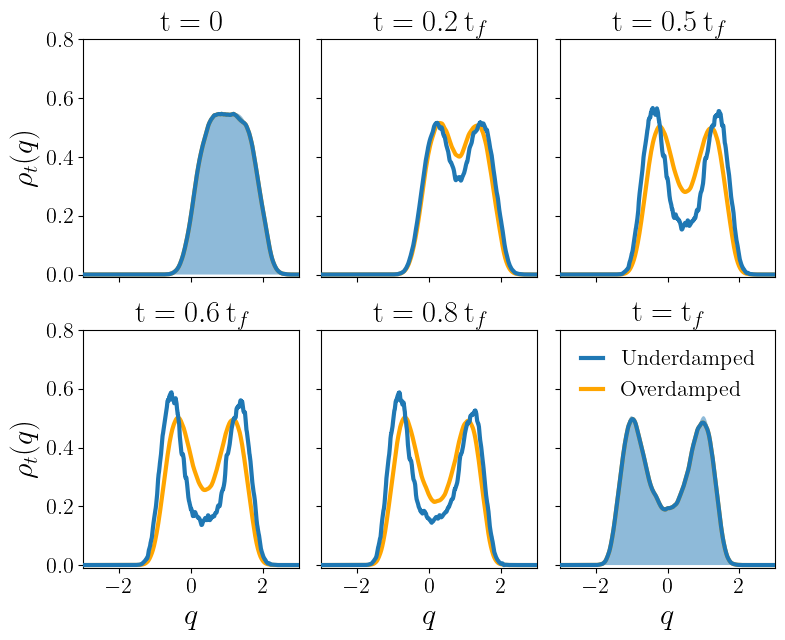

In [ ]:

def plot_pdf_nucleation(tcurr,title,labels,loc):
  '''This functions plots a distribution and labels it

  input:
  -tcurr: the time in terms of t0 to plot
  -title: title of the graph (if using)
  -label: label of the panel
  -loc: location as a matplotlib subplot code (or gridspec)

  output:
  -plot in location given by loc with the overdamped(in orange)
  and underdamped (in blue) of the marginal density of the position
  '''

  # t0 distribution
  plt.subplot(loc)
  plt.title(title, loc = "center", fontsize=fontsizetitles)

  plt.plot(q_axis(tcurr),distribution(tcurr),color=c1,lw=lw,  label =r"$T=5$",zorder = 10000)
  plt.plot(q_axis(tcurr),rho(tcurr),color="orange",lw=lw)

  ax = plt.gca()
  format_dist_axes(ax)

  #ax.set_xticklabels([])
  ax.tick_params(axis='y', labelsize=fontsizeticks)

plt.figure(figsize=(8,6.5))
plot_pdf_nucleation(0,"$\mathrm{t} = 0$",None,231)
plt.fill_between(q_axis(0),p_initial(q_axis(0)),alpha = 0.5)
plt.gca().set_xticklabels([])
plt.gca().set_ylabel(r"$\rho_t(q)$",fontsize=fontsizetitles)
plot_pdf_nucleation(0.2*T,"$\mathrm{t} = 0.2\,\mathrm{t}_f$",None,232)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plot_pdf_nucleation(0.5*T,"$\mathrm{t} = 0.5\,\mathrm{t}_f$",None,233)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plot_pdf_nucleation(0.6*T,"$\mathrm{t} = 0.6\,\mathrm{t}_f$",None,234)
plt.gca().set_ylabel(r"$\rho_t(q)$",fontsize=fontsizetitles)
plt.gca().set_xlabel(r"$q$",fontsize=fontsizetitles)
plot_pdf_nucleation(0.8*T,"$\mathrm{t} = 0.8\,\mathrm{t}_f$",None,235)
plt.gca().set_yticklabels([])
plt.gca().set_xlabel(r"$q$",fontsize=fontsizetitles)
plot_pdf_nucleation(T,"$\mathrm{t} = \mathrm{t}_f$",None,236)
plt.fill_between(q_axis(T),p_final(q_axis(T)),alpha = 0.5)
plt.gca().set_xlabel(r"$q$",fontsize=fontsizetitles)
plt.legend(labels = ["Underdamped","Overdamped"],
           prop={"size":fontsizeticks},
           frameon = False,
           loc = "upper center",
           handlelength = 1)
plt.gca().set_yticklabels([])

plt.tight_layout()
#plt.show()
plt.savefig("ep_distributions_T2.pdf")

###Total Cost Plot

In [ ]:
#append the csvs
#df5_cost = pd.read_csv("df_ep_costsT5_v3.csv",index_col =0)
#df1_cost = pd.read_csv("df_ep_costsT1_v3.csv",index_col =0)
#df50_cost = pd.read_csv("df_ep_costsT50_v4.csv",index_col =0)
df2_cost = pd.read_csv("df_ep_costsT2.csv",index_col =0)

DFTEMP = pd.read_csv("ep_costs_v5.csv",index_col =0) #pd.concat([df1_cost,df5_cost])
df_ep_cost_all = pd.concat([DFTEMP,df2_cost])
df_ep_cost_all = df_ep_cost_all.reset_index(drop=True)
df_ep_cost_all.to_csv("ep_costs_v6.csv")

In [70]:
#get the results from csv and plot

#gridspec
gs_costs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[1.3, 1, 1])


df_ep_cost_all = pd.read_csv("ep_costs_v6.csv",index_col=0)

plt.figure(figsize = (8,7))

plt.subplot(gs_costs[0])
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==2].g,df_ep_cost_all[df_ep_cost_all.Tf==2].EPcost,label=r"EP Cost")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==2].g,df_ep_cost_all[df_ep_cost_all.Tf==2].Firstterm,label=r"Overdamped Bound")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==2].g,(1+df_ep_cost_all[df_ep_cost_all.Tf==2].g)*df_ep_cost_all[df_ep_cost_all.Tf==2].ODBound,linestyle="dashed",lw=1,label=r"$\mathcal{W}_2$-distance")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
ax = plt.gca()
format_log_axes(ax)
ax.set_xticklabels([]) #remove x axis lables
#ax.set_ylabel(r"$\mathcal{E}$",fontsize = fontsizetitles)
ax.minorticks_off()
ax2 = ax.twinx()
ax2.set_ylabel(r"$\mathrm{t}_f=2$",rotation=270,fontsize = fontsizetitles,labelpad = 30)
ax2.set_yticks([])

plt.subplot(gs_costs[1])
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==5].g,df_ep_cost_all[df_ep_cost_all.Tf==5].EPcost,label=r"EP Cost")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==5].g,df_ep_cost_all[df_ep_cost_all.Tf==5].Firstterm,label=r"Overdamped Bound")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==5].g,(1+df_ep_cost_all[df_ep_cost_all.Tf==5].g)*df_ep_cost_all[df_ep_cost_all.Tf==5].ODBound,linestyle="dashed",lw=1,label=r"$\mathcal{W}_2$-distance")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.ylim((5.1,6.05))
format_log_axes(plt.gca())
ax = plt.gca()
ax.set_xticklabels([]) #remove x axis lables
ax.set_ylabel(r"Mean Entropy Production",fontsize = fontsizetitles,labelpad =18)
#ax.set_ylabel(r"$\mathcal{E}$", fontsize=fontsizetitles)
ax.minorticks_off()
ax2 = ax.twinx()
ax2.set_ylabel(r"$\mathrm{t}_f=5$",rotation=270, fontsize=fontsizetitles,labelpad = 30)
ax2.set_yticks([])

#####
plt.subplot(gs_costs[2])
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==50].g,df_ep_cost_all[df_ep_cost_all.Tf==50].EPcost,label=r"Average Entropy Production")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==50].g,df_ep_cost_all[df_ep_cost_all.Tf==50].Firstterm,label=r"Overdamped Bound")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.plot(df_ep_cost_all[df_ep_cost_all.Tf==50].g,(1+df_ep_cost_all[df_ep_cost_all.Tf==50].g)*df_ep_cost_all[df_ep_cost_all.Tf==50].ODBound,linestyle="dashed",lw=1,label=r"Squared $\mathcal{W}_2$-distance")#,yerr=0.04,ecolor="black",capsize=4,elinewidth=1,label=r"EP cost $\pm 0.04$")
plt.ylim((0.51,0.585))
plt.legend(prop = {"size": fontsizeticks},handlelength=1,loc = "lower right")
ax = plt.gca()
format_log_axes(ax)
ax.set_xlabel(r"$g$",fontsize = fontsizetitles)
#ax.set_ylabel(r"$\mathcal{E}$",fontsize = fontsizetitles)
ax.tick_params(axis='x', labelsize=fontsizeticks)
ax.minorticks_off()
ax2 = ax.twinx()
ax2.set_ylabel(r"$\mathrm{t}_f=50$",rotation=270, fontsize=fontsizetitles,labelpad = 30)
ax2.set_yticks([])

plt.subplots_adjust(left  = 0.2 , # the left side of the subplots of the figure
                    right = 0.9  ,  # the right side of the subplots of the figure
                    bottom = 0.12,   # the bottom of the subplots of the figure
                    top = 0.95,      # the top of the subplots of the figure
                    wspace = 0.2,   # the amount of width reserved for blank space between subplots
                    hspace = 0.05)   # the amount of height reserved for white space between subplots

plt.savefig("ep_cost_all.eps")
plt.savefig("ep_cost_all.pdf")
plt.savefig("ep_cost_all.png")
plt.close()

##Evolution by the Underdamped Dynamics

In non-dimensional coordinates, the underdamped evolution follows

\begin{equation}
\begin{split}
d q_t &= \varepsilon(p_t- g\varepsilon\partial U(q_t)dt + \sqrt{2g}d \omega^{(1)}_t) \\
d p_t &= - \left(p_t+\varepsilon\partial U(q_t)\right)dt + \sqrt{2}d \omega^{(2)}_t
\end{split}
\end{equation}

In [72]:

#function to get underdamped distribution
def distribution(t0):
  t2 = round(t0*(epsilon**2),dps)
  dist_temp = df[df.t==t2].UDpdf.to_numpy()
  return dist_temp

#function to get underdamped drift
def optimal_drift(t0):
  t2 = round(t0*(epsilon**2),dps)
  drift_temp = df[df.t==t2].UDdrift.to_numpy()
  return drift_temp

#function for interpolated dsigma
def dsigma_interp(t0,q):
  t2 = round(epsilon**2*t0,dps)
  q_temp = q_axis(t0)
  dsig_temp = dsigma(t0)
  w_temp = rho(t0)

  interp_dsig = sci.splrep(q_temp, dsig_temp,w = w_temp,k=3)
  return sci.splev(q,interp_dsig)

#function for interpolated DU
def underdamped_drift_interp_function(t0,g):

  q_temp = q_axis(t0)

  w_temp = distribution(t0)
  dsig_temp_underdamped = optimal_drift(t0)
  #dsigout = generic_filter(dsig_temp_underdamped,sc.mean,size=100)
  interp_dsig_underdamped = sci.splrep(q_temp, dsig_temp_underdamped, w=w_temp, k=5)

  return interp_dsig_underdamped

def underdamped_drift_interp(t0,q,g):

  return -sci.splev(q,underdamped_drift_interp_function(t0,g),ext=0)


#function for derivative of interpolated DU
def d_underdamped_drift_interp(t0,q,g):

  return -sci.splev(q,underdamped_drift_interp_function(t0,g),der=1,ext=5)


In [73]:
#set up plots
#panel labels:
label_titles = ["(a)","(b)","(c)","(d)","(e)","(f)"]

# Plotting the distributions
fig_distributions = plt.figure(figsize=(8,6))

#create plot grid
gs_distributions = fig_distributions.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])

#what times to plot
times_to_save = [0,0.2,0.4,0.6,0.8,1]
times_to_save = np.round(times_to_save,4)

hist_plot_titles = [f"t = {times_to_save[j]}"+r"$\,t_f$" for j in range(0,len(times_to_save))]

#function for plotting
def plot_distributions_ep(plot_index,underdamped_data,overdamped_data,tcurr):

  """
  Function that plots the histogram, underdamped and overdamped distributions in a lil square

  input:
  -plot_index: where to put the plot
  -histogram data
  -current t0
  """


  x_ind = int(np.floor(plot_index/3))
  y_ind = plot_index % 3
  #get plot location
  ax = fig_distributions.add_subplot(gs_distributions[x_ind,y_ind])
  ax.set_title(hist_plot_titles[plot_index], loc = "center", fontsize=fontsizetitles)
  ax.text(-2.6,0.5,label_titles[plot_index],fontsize = fontsizetitles)
  #plot the histograms
  ax.hist(underdamped_data, range=(xmin,xmax), color = c1, alpha = 0.5,bins = 100,density = True)
  #ax.hist(overdamped_data, color = "orange", alpha = 0.5,bins =30,density = True)

  ax.plot(q_axis(tcurr),distribution(tcurr),color=c1,lw=lw,  label =r"$T=2$",zorder = 10000)
  ax.plot(q_axis(tcurr),rho(tcurr),color="orange",lw=lw)

  #format the axes
  format_dist_axes(ax)
  ax.set_ylim((-0.01,0.6))

  ax.tick_params(axis='y', labelsize=fontsizeticks)
  if x_ind ==0:
    ax.set_xticklabels([])
  else:
    ax.set_xlabel(r"$q$",fontsize = fontsizetitles)

  if y_ind == 0:
    ax.set_ylabel(r"$\rho(q,t)$",fontsize = fontsizetitles)


<Figure size 800x600 with 0 Axes>

In [74]:
##SET UP: RUN BEFORE THE SIMULATIONS
#set up dataframe for cumulant results
df_ep_cumulants_exp = pd.DataFrame(columns = ["g","t0","pos_var","mom_var","mom_mean","pos_mean","xcorr","OD_mean","OD_var"])

#add g and t0 cols
#df_ep_cumulants_exp["g"] = np.ones(t_steps)*g
#df_ep_cumulants_exp["t0"] = times_t0

##Evolve the underdamped dynamics using EM SCHEME
plot_index = 0

samples = 1000000

evo_choice = np.linspace(xmin,xmax,samples*10) #starting points to choose from for histograms
sample_weights = p_initial(evo_choice)
sample_weights /= sum(sample_weights)

x_evo = npr.choice(evo_choice, size = samples, p = sample_weights)
q_evo_UD_prev = npr.choice(evo_choice, size = samples, p = sample_weights) #position from assigned initial dist.
p_evo_UD_prev = npr.randn(samples) #momentum, independent standard Gaussian samples


#compute mean and variance of p and q using MLE at t=0
covmat = np.cov(q_evo_UD_prev,p_evo_UD_prev)

df_ep_cumulants_exp.loc[len(df_ep_cumulants_exp)] = [g, times_t0[0],
                                                     covmat[0,0],
                                                     covmat[1,1],
                                                     np.mean(p_evo_UD_prev),
                                                     np.mean(q_evo_UD_prev),
                                                     covmat[0,1],
                                                     np.nanmean(x_evo),
                                                     np.var(x_evo)]


In [75]:

for i in range(0,len(times_t0)-1):
#enumerate(times_t0[0:-1]):
  print(i)
  #plot the selected times
  if (times_t0[i]/T in times_to_save):
    plot_distributions_ep(plot_index,q_evo_UD_prev,x_evo,times_t0[i])
    plot_index += 1

  #overdamped
  #evolution in t2
  x_evo = x_evo - (h_step)*dsigma_interp(times_t0[i],x_evo) + np.sqrt(2*g*h_step)*npr.randn(samples)

  #underdamped
  #evolution in t0
  h0_step = h_step/(epsilon**2)
  q_evo_UD_new = q_evo_UD_prev + epsilon*h0_step*(p_evo_UD_prev-g*epsilon*underdamped_drift_interp(times_t0[i],q_evo_UD_prev,g)) + epsilon*np.sqrt(2*g*h0_step)*npr.randn(len(p_evo_UD_prev))
  p_evo_UD_new = p_evo_UD_prev - (p_evo_UD_prev + epsilon*underdamped_drift_interp(times_t0[i],q_evo_UD_new,g))*h0_step + np.sqrt(2*h0_step)*npr.randn(len(p_evo_UD_prev))


  #idx = get_rhomask(times_t0[i])
  #qmin = np.min(q_axis(times_t0[i]))
  #qmax = np.max(q_axis(times_t0[i]))
  #remove escaped particles
  q_evo_UD_new[q_evo_UD_new>xmax] = np.nan
  q_evo_UD_new[q_evo_UD_new<xmin] = np.nan

  #remove nans and infs
  good_idx_q = np.argwhere(~np.isnan(q_evo_UD_new)) #np.where(q_evo_UD_mid != [np.nan,np.inf,-np.inf])
  good_idx_p = np.argwhere(~np.isnan(p_evo_UD_new)) #np.where(p_evo_UD_new != [np.nan,np.inf,-np.inf])

  idx_out = np.intersect1d(good_idx_q,good_idx_p)
  #go forward without nans and infs
  q_evo_UD_prev = q_evo_UD_new[idx_out]
  p_evo_UD_prev = p_evo_UD_new[idx_out]

  covmat = np.cov(q_evo_UD_prev,p_evo_UD_prev)

  #compute mean and variance of p and q using MLE
  df_ep_cumulants_exp.loc[len(df_ep_cumulants_exp)] = [g, times_t0[i+1],
                                                           covmat[0,0],
                                                            covmat[1,1],
                                                            np.mean(p_evo_UD_prev),
                                                            np.mean(q_evo_UD_prev),
                                                            covmat[0,1],
                                                            np.nanmean(x_evo),
                                                            np.var(x_evo)]





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [76]:
#add initial time plot
plot_distributions_ep(plot_index,q_evo_UD_prev,x_evo,T);


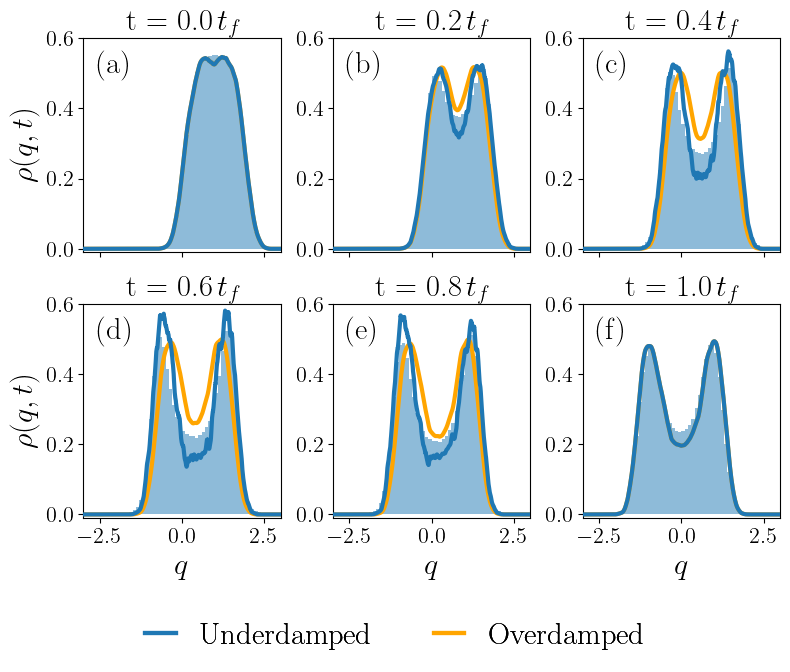

In [80]:

#add legend
orange_line = mlines.Line2D([], [],color="orange",lw=lw)
blue_line = mlines.Line2D([], [],color=c1,lw=lw)
legend = fig_distributions.legend(handles=[blue_line,orange_line],
          labels = ["Underdamped","Overdamped"],
           #prop={"size":fontsizeticks},
          fontsize = fontsizetitles,
          frameon = False,
          handlelength = 1,
          ncols = 2,
          loc="upper center", bbox_to_anchor=(0.5, 0))


bbox = legend.get_window_extent(fig_distributions.canvas.get_renderer()).transformed(fig_distributions.transFigure.inverted())

fig_distributions.tight_layout()#rect=(0, bbox.y1, 1, 1), h_pad=0.5, w_pad=0.5)

#format
fig_distributions

In [82]:
#fig_distributions.savefig("ep_histogram_T2_v6.pdf")

#fig_distributions.savefig("ep_histogram_T2_v6.eps")


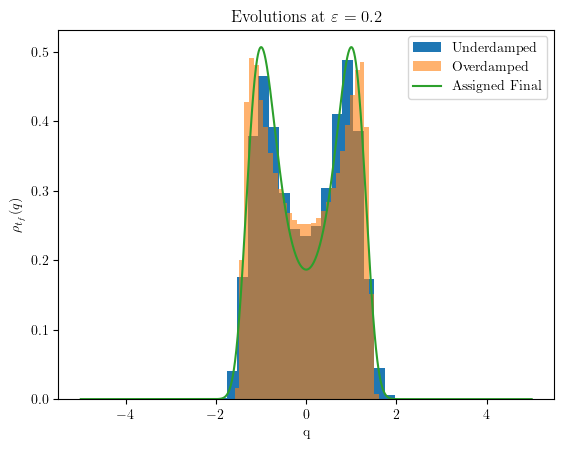

In [ ]:
(n, bins, patches) = plt.hist(q_evo_UD_prev,bins =30,density = True, label="Underdamped")
plt.hist(x_evo,bins =30,density = True, label="Overdamped",alpha=0.6)
plt.plot(q_axis(T),p_final(q_axis(T)),label="Assigned Final")

plt.legend()
plt.xlabel("q")
plt.ylabel(r"$\rho_{t_f}(q)$")
plt.title(rf"Evolutions at $\varepsilon={epsilon}$")

#plt.savefig("UD_evolution_eps005.pdf")
plt.show()

In [37]:
#save the computed cumulants
df_ep_cumulants_exp.to_csv("ep_cumulants_simulated_v7.csv")
#files.download("ep_cumulants_simulated_v5.csv")

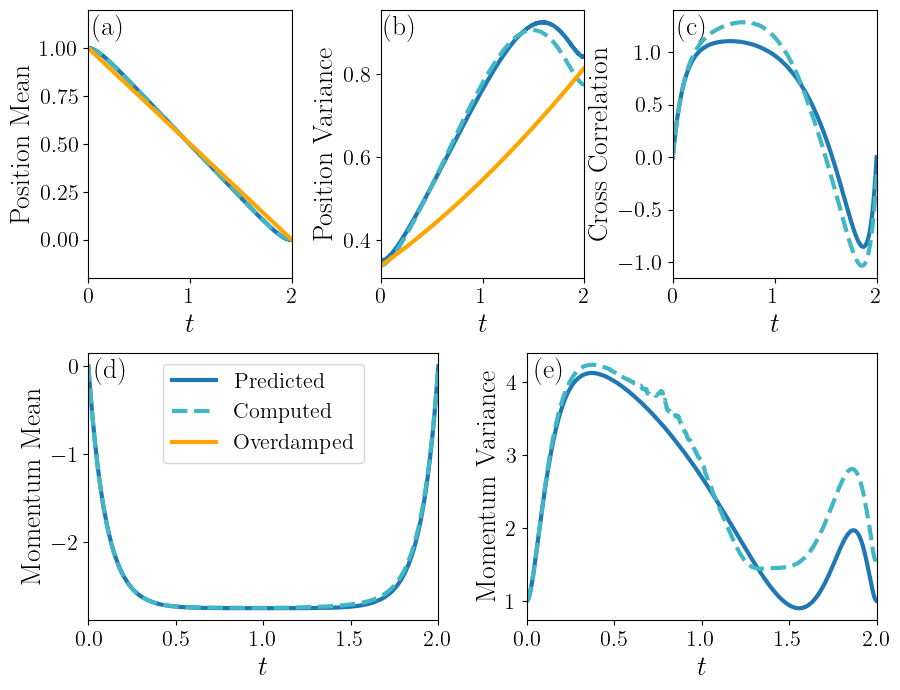

In [71]:
titlex = 0.1
#cumulants compared to experimental result
df_ep_cumulants = pd.read_csv("ep_cumulantsT2_v2.csv",index_col=0)
df_ep_cumulants_exp = pd.read_csv("ep_cumulants_simulated_v7.csv",index_col=0)
c2_cumulants = "#41b6c4"

times_evolution = df_ep_cumulants_exp.t0.unique()
cumulant_plot_times = df_ep_cumulants[df_ep_cumulants.g==g].t0.unique()


# Plotting
plt.figure(figsize=(9, 7))#, constrained_layout=True)

# Create a 1x5 grid with different widths for the bottom row
gs_cumulants = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1,1,1], height_ratios=[1, 1])
                              #hspace = 0.3,wspace = 2.3)
                              #(1, 2, width_ratios=[6, 4], figure=fig)


# position mean
plt.subplot(gs_cumulants[0, 0:2])
plt.plot(cumulant_plot_times,  df_ep_cumulants[df_ep_cumulants.g==0.01].pos_mean,color=c1,lw=lw,label="Predicted")
plt.plot(times_evolution, df_ep_cumulants_exp.pos_mean,lw=lw,color=c2_cumulants,linestyle="dashed",label="Simulated")
plt.plot(times_evolution, df_ep_cumulants_exp.OD_mean,lw=lw,color = "orange",label="Overdamped")
plt.title('(a)',fontweight = "bold",fontsize = fontsizetitles-2,pad = titlepad,x = titlex, y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_ylabel('Position Mean',fontsize = fontsizetitles-2)
handles,labels = ax.get_legend_handles_labels()
ax.set_ylim((-0.2,1.2))
ax.set_xlabel(r'$t$',fontsize = fontsizetitles-2)

# position variance
plt.subplot(gs_cumulants[0, 2:4])
plt.plot(cumulant_plot_times, df_ep_cumulants[df_ep_cumulants.g==0.01].pos_var,color=c1,lw=lw)
plt.plot(times_evolution, df_ep_cumulants_exp.pos_var,color=c2_cumulants,linestyle="dashed",lw=lw)
plt.plot(times_evolution, df_ep_cumulants_exp.OD_var,color="orange",lw=lw)
plt.title('(b)',fontweight = "bold",fontsize = fontsizetitles-2,pad = titlepad,x = titlex, y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_ylabel('Position Variance',fontsize = fontsizetitles-2)
ax.set_xlabel(r'$t$',fontsize = fontsizetitles-2)

# cross corr
plt.subplot(gs_cumulants[0, 4:])
plt.plot(cumulant_plot_times, df_ep_cumulants[df_ep_cumulants.g==0.01].xcorr,color=c1,lw=lw)
plt.plot(times_evolution, df_ep_cumulants_exp.xcorr,color=c2_cumulants,linestyle="dashed",lw=lw)
plt.title('(c)',fontweight = "bold",fontsize = fontsizetitles-2,pad = titlepad,x = titlex, y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_ylabel('Cross Correlation',fontsize = fontsizetitles-2)
ax.set_xlabel(r'$t$',fontsize = fontsizetitles-2)


# momentum mean
plt.subplot(gs_cumulants[1,:3])
plt.plot(cumulant_plot_times, df_ep_cumulants[df_ep_cumulants.g==0.01].mom_mean,color=c1,lw=lw)
plt.plot(times_evolution, df_ep_cumulants_exp.mom_mean,color=c2_cumulants,linestyle="dashed",lw=lw)
plt.title('(d)',fontweight = "bold",fontsize = fontsizetitles-2,pad = titlepad,x = titlex*(2/3), y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_xlabel(r'$t$',fontsize = fontsizetitles-2)
ax.set_ylabel('Momentum Mean',fontsize = fontsizetitles-2)
plt.legend(handles = handles, labels =["Predicted","Computed", "Overdamped"],prop={"size":fontsizeticks}
           ,loc="upper center")

# momentum variance
mom_var = plt.subplot(gs_cumulants[1, 3:])
plt.plot(cumulant_plot_times,  df_ep_cumulants[df_ep_cumulants.g==0.01].mom_var,color=c1,lw=lw)
plt.plot(times_evolution, df_ep_cumulants_exp.mom_var,color=c2_cumulants,linestyle="dashed",lw=lw)
plt.title('(e)',fontweight = "bold",fontsize = fontsizetitles-2,pad = titlepad,x = titlex*(2/3), y =titley,zorder = 1000000)
ax = format_axes(plt.gca(),fontsize)
ax.set_xlabel(r'$t$',fontsize = fontsizetitles-2)
ax.set_ylabel('Momentum Variance',fontsize = fontsizetitles-2)

plt.tight_layout()

#plt.show()
plt.savefig("ep_cumulants_histogram.pdf")
plt.savefig("ep_cumulants_histogram.eps")

In [ ]:
files.download("ep_cumulants_histogram.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#momentum variance plot
##momentum mean and var only

df_ep_cumulants = pd.read_csv("df_ep_cumulants_T5_final.csv",index_col=0)#pd.read_csv("ep_cumulants_g2.csv",index_col=0)

times_t0 = df_ep_cumulants[df_ep_cumulants.g==0.0001].t0.unique()
lw = 3

c1_cumulants = "#7fcdbb"
c2_cumulants = "#41b6c4"
c3_cumulants = "#2c7fb8"
c4_cumulants = "#253494"
#

cumulant_plot_times = df_ep_cumulants[df_ep_cumulants.g==0.0001].t0.unique()
times_evolution = df_ep_cumulants_exp[df_ep_cumulants_exp.g==0.0001].t0.unique()


plt.figure(figsize = (8,6))

#format axes
plt.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.1].mom_var,label=r"$g=10^{-1}$",lw=lw,c = c1_cumulants)
plt.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.01].mom_var,label=r"$g=10^{-2}$",lw=lw,c = c2_cumulants)
plt.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.001].mom_var,label=r"$g=10^{-3}$",lw=lw,c = c3_cumulants)
plt.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.0001].mom_var,label=r"$g=10^{-4}$",lw=lw,c = c4_cumulants)

plt.plot(times_evolution, df_ep_cumulants_exp[df_ep_cumulants_exp.g==0.0001].mom_var,
         lw=lw,linestyle = "dashed", color="orange")
plt.ylabel("Momentum Variance",fontsize=fontsizetitles)
#plt.text(0.1, 1.14,"(b)",fontweight="bold",fontsize=fontsizetitles)

ax = plt.gca()
format_axes(ax,fontsizetitles)
ax.set_xlim(-0.05,5.05)

ax1 = ax.inset_axes([0.9,1.03,2.5,0.1], transform=ax.transData)
ax1.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.1].mom_mean,label=r"$g=10^{-1}$",lw=2,c = c1_cumulants)
ax1.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.01].mom_mean,label=r"$g=10^{-2}$",lw=2,c = c2_cumulants)
ax1.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.001].mom_mean,label=r"$g=10^{-3}$",lw=2,c = c3_cumulants)
ax1.plot(cumulant_plot_times,df_ep_cumulants[df_ep_cumulants.g==0.0001].mom_mean,label=r"$g=10^{-4}$",lw=2,c = c4_cumulants)

ax1.plot(times_evolution, df_ep_cumulants_exp[df_ep_cumulants_exp.g==0.0001].mom_mean,
         lw=lw,linestyle = "dashed", color="orange")

format_axes(ax1,fontsizetitles)

ax1.set_ylabel("Mom. Mean",fontsize=fontsizetitles)

ax1.set_xlim(-0.05,5.05)
#ax.set_ylim(0.97,1.155)

plt.xlabel(r"$\mathrm{t}$",fontsize=fontsizetitles)
#ax.legend(bbox_to_anchor=(0.1, 0.972), bbox_transform=ax.transData,prop = {"size": fontsizeticks },frameon=True, ncol=2,loc = "lower left",handlelength=1)
ax.legend(labels =["Predicted","Computed"],prop = {"size": fontsizeticks },
          frameon=False, ncol=1,loc = "upper right",handlelength=2)


plt.tight_layout()
plt.savefig("ep_land_momentumplot.png")
#plt.savefig("ep_land_mom_cumulants.pdf")
#plt.savefig("ep_land_mom_cumulants.eps")

plt.close();


FileNotFoundError: [Errno 2] No such file or directory: 'df_ep_cumulants_T5_final.csv'

##Calculate momentum variance integral

In [ ]:
#compute and save drifts in terms of g
##compute cumulants at different g and save
df_ep_drifts = df.copy()
df_ep_drifts.drop(columns=["dsigma","ptx","logptx","df11","UDpdf"],inplace=True)
df_ep_drifts["g"] = g

##add distributions as function to get sigma
for gi in gs[0:-1]:
  #new dataframe
  df_ep_drifts_g = pd.DataFrame(columns=df_ep_drifts.columns)
  df_ep_drifts_g["t"] = df_ep_drifts[df_ep_drifts["g"]==0.0001].t
  df_ep_drifts_g["x"] = df_ep_drifts[df_ep_drifts["g"]==0.0001].x

  #get opt drift
  minus_du = []
  for t0 in times_t0:
    result = calculate_optimal_drift(t0,gi)
    minus_du.append(result)

  #get results to put into dataframe
  minus_du = np.concatenate(minus_du, axis=0 )

  df_ep_drifts_g['UDdrift'] = minus_du
  df_ep_drifts_g["g"] = gi*np.ones(len(df))

  #append to ep_drifts
  df_ep_drifts = pd.concat([df_ep_drifts,df_ep_drifts_g])

df_ep_drifts.reset_index(drop=True);


In [ ]:
mom_var_integral = np.zeros(len(gs))
mom_mean_integral = np.zeros(len(gs))
laplacian_protocol = np.zeros(len(gs))
ep_costs = np.zeros(len(gs))
od_bounds = np.zeros(len(gs))
lower_bounds = np.zeros(len(gs))

In [ ]:
#compare the evolution using the assigned initial condition
def get_opt_drift(t0,g):
  t2 = round(t0*(epsilon**2),dps)
  drift_temp = df_ep_drifts[(df_ep_drifts.t==t2) & (df_ep_drifts.g == g)].UDdrift.to_numpy()
  return drift_temp

In [ ]:
for gi in enumerate(gs):
  mom_var_integral[gi[0]] = np.trapz(df_ep_cumulants[df_ep_cumulants["g"]==gi[1]].mom_var-1,times_t0)
  ep_costs[gi[0]] = entropy_production_cost(5,gi[1])
  od_bounds[gi[0]] = first_term(5,gi[1])
  #lower_bounds[g[0]] = od_bound(5,gi[1])
  mom_mean_integral[gi[0]] = np.trapz(df_ep_cumulants[df_ep_cumulants["g"]==gi[1]].mom_mean**2,times_t0)




In [ ]:
lap_drift = np.zeros(len(times_t0))
#laplacian of drift at g=g
for t0 in enumerate(times_t0):

  integrand = distribution(t0[1])*((underdamped_drift_interp(t0[1],q_axis(t0[1]),g)**2) - d_underdamped_drift_interp(t0[1],q_axis(t0[1]),g))

  lap_drift[t0[0]] = np.trapz(integrand,q_axis(t0[1]))

laplacian_integral = np.trapz(lap_drift,t2_vec)


In [ ]:
#gibbs shannon entropy
gibbs_shannon_entropy = constant.Boltzmann*np.sum((pi) *np.log(pi/pf))


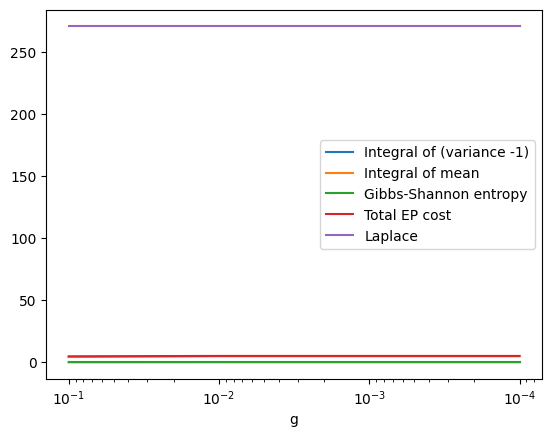

In [ ]:
# plot the same data on both Axes
plt.plot(gs,mom_var_integral,label="Integral of (variance -1)")
plt.plot(gs,mom_mean_integral,label="Integral of mean")
plt.plot(gs,gibbs_shannon_entropy*np.ones(len(gs)),label="Gibbs-Shannon entropy")
#plt.plot(gs,mom_var_integral+mom_mean_integral,label="Terms 2+3")
plt.plot(gs,ep_costs,label="Total EP cost")
#plt.plot(gs,lower_bounds,label="Lower Bound")
plt.plot(gs,gs*laplacian_integral,label="Laplace")

plt.gca().invert_xaxis()
plt.gca().set_xscale('log')
plt.gca().set_xlabel("g")
plt.legend(loc="center right")
#plt.savefig("bounds.pdf")
plt.show()

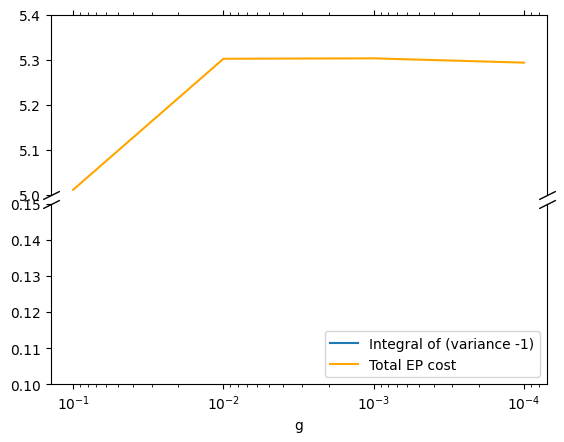

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes

# plot the same data on both Axes
ax2.plot(gs,mom_var_integral,label="Integral of (variance -1)")
ax2.plot(gs,ep_costs,label="Total EP cost",color="orange")
ax1.plot(gs,mom_var_integral,label="Integral of (variance -1)")
ax1.plot(gs,ep_costs,label="Total EP cost",color="orange")
ax2.set_ylim((0.1,0.15))
ax1.set_ylim((5,5.4))

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax2.invert_xaxis()
ax2.set_xscale('log')
ax2.set_xlabel("g")
plt.legend(loc="lower right")
plt.savefig("ep_vs_momvar.pdf")


In [ ]:
df_momvar_costs = pd.DataFrame(columns=["g","mom_var_integral","totalepcost","firstterm","lowerbound"])
df_momvar_costs.g = gs
df_momvar_costs.mom_var_integral = mom_var_integral
df_momvar_costs.totalepcost = ep_costs
df_momvar_costs.firstterm = od_bounds
df_momvar_costs.lowerbound = lower_bounds


,g,mom_var_integral,totalepcost,firstterm,lowerbound
0,0.1000,0.114667,5.011220,4.751001,4.751843
1,0.0100,0.136669,5.301851,5.174357,5.175274
2,0.0010,0.135541,5.302778,5.220880,5.221805
3,0.0001,0.134175,5.293229,5.225578,5.226504


In [ ]:

plt.hist(q_evo_UD_prev,bins =30,density = True, label="Underdamped")
plt.hist(x_evo,bins =30,density = True, label="Overdamped",alpha=0.6)
plt.plot(q_axis(T),p_final(q_axis(T)),label="Assigned Final")

plt.legend()
plt.xlabel("q")
plt.ylabel(r"$\rho_{t_f}(q)$")
plt.title(rf"Evolutions at $\varepsilon={epsilon}$")

plt.savefig("UD_evolution_eps02_new.pdf")
plt.show()

###Momentum Variance plot


In [ ]:
##momentum mean and var only

df_ep_cumulants = pd.read_csv("df_ep_cumulants8.csv",index_col=0)#pd.read_csv("ep_cumulants_g2.csv",index_col=0)
df_calculated_cumulants =
times_t0 = df_ep_cumulants[df_ep_cumulants.g==0.1].t0.unique()
lw = 3

c1 = "#7fcdbb"
c2 = "#41b6c4"
c3 = "#2c7fb8"
c4 = "#253494"
#

plt.figure(figsize = (8,6))

#format axes
plt.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.1].mom_var,label=r"$g=10^{-1}$",lw=lw,c = c1)
plt.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.01].mom_var,label=r"$g=10^{-2}$",lw=lw,c = c2)
plt.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.001].mom_var,label=r"$g=10^{-3}$",lw=lw,c = c3)
plt.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.0001].mom_var,label=r"$g=10^{-4}$",lw=lw,c = c4)
plt.ylabel("Momentum Variance",fontsize=fontsizetitles)
#plt.text(0.1, 1.14,"(b)",fontweight="bold",fontsize=fontsizetitles)

ax = plt.gca()
format_axes(ax,fontsizetitles)
ax.set_xlim(-0.05,5.05)

ax1 = ax.inset_axes([0.95,1.06,3.5,0.08], transform=ax.transData)
#ax1 = plt.gca()
ax1.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.1].mom_mean,label=r"$g=10^{-1}$",lw=2,c = c1)
ax1.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.01].mom_mean,label=r"$g=10^{-2}$",lw=2,c = c2)
ax1.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.001].mom_mean,label=r"$g=10^{-3}$",lw=2,c = c3)
ax1.plot(times_t0,df_ep_cumulants[df_ep_cumulants.g==0.0001].mom_mean,label=r"$g=10^{-4}$",lw=2,c = c4)
format_axes(ax1,fontsizetitles)

ax1.set_ylabel("Mom. Mean",fontsize=fontsizetitles)

ax1.set_xlim(-0.05,5.05)
ax.set_ylim(0.97,1.155)

plt.xlabel(r"$\mathrm{t}$",fontsize=fontsizetitles)
ax.legend(bbox_to_anchor=(0.1, 0.972), bbox_transform=ax.transData,prop = {"size": fontsizeticks },frameon=True, ncol=2,loc = "lower left",handlelength=1)


plt.tight_layout()
plt.savefig("ep_land_mom_cumulants.png")
#plt.savefig("ep_land_mom_cumulants.pdf")
#plt.savefig("ep_land_mom_cumulants.eps")

plt.close();

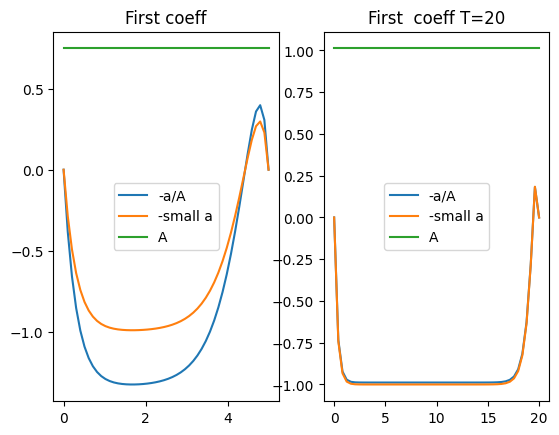

In [ ]:
plt.subplot(121)
plt.plot(times_5, [coeff1_df11(5,0.1,t0) for t0 in times_5], label = "-a/A")
plt.plot(times_5, [-a(t0,0.1,5) for t0 in times_5], label = "-small a")
plt.plot(times_5, [A_fun(5,0.1) for t0 in times_5], label = "A")
#plt.plot(times_20, [coeff2_df11(20,0.1,t0) for t0 in times_20], label = "T=20")
plt.title("First coeff")
plt.legend()
plt.subplot(122)
plt.plot(times_20, [coeff1_df11(20,0.1,t0) for t0 in times_20], label = "-a/A")
plt.plot(times_20, [-a(t0,0.1,20) for t0 in times_20], label = "-small a")
plt.plot(times_20, [A_fun(20,0.1) for t0 in times_20], label = "A")
plt.legend()
plt.title("First  coeff T=20")

plt.savefig("coefficients.pdf")

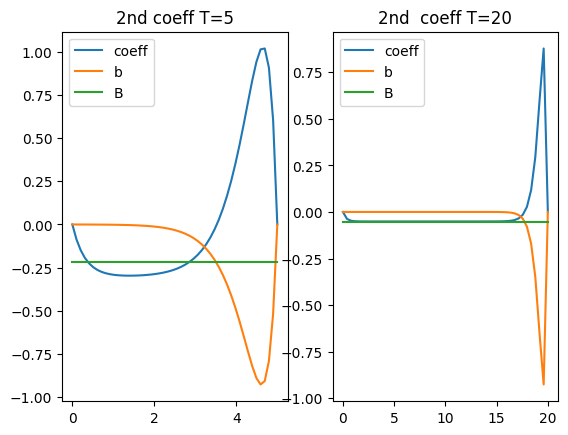

In [ ]:
plt.subplot(121)
plt.plot(times_5, [coeff2_df11(5,0.1,t0) for t0 in times_5], label = "coeff")
plt.plot(times_5, [b(t0,0.1,5) for t0 in times_5], label = "b")
plt.plot(times_5, [B_fun(5,0.1) for t0 in times_5], label = "B")
#plt.plot(times_20, [coeff2_df11(20,0.1,t0) for t0 in times_20], label = "T=20")
plt.title("2nd coeff T=5")
plt.legend()
plt.subplot(122)
plt.plot(times_20, [coeff2_df11(20,0.1,t0) for t0 in times_20], label = "coeff")
plt.plot(times_20, [b(t0,0.1,20) for t0 in times_20], label = "b")
plt.plot(times_20, [B_fun(20,0.1) for t0 in times_20], label = "B")
plt.legend()
plt.title("2nd  coeff T=20")

plt.savefig("coefficients2.pdf")